# Data Preprocessing and Augmentation

In [15]:
import os
import numpy as np
import torch
from skimage.io import imread
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

In [16]:
test_path = "../Dataset/Test/color"
test_label_path = "../Dataset/Test/label"
train_path = "../Dataset/TrainVal/color"
train_label_path = "../Dataset/TrainVal/label"

In [17]:

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = os.listdir(image_dir)
    
    def __len__(self):
        return len(self.image_filenames)
    
    def get_label_filename(self, idx):
        return self.image_filenames[idx].replace(".jpg", ".png")
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, get_label_filename(idx))

        image = imread(image_path)
        mask = imread(mask_path)

        # Convert RGBA to RGB if necessary
        if image.shape[2] == 4:
            image = image[:, :, :3]

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        return image, mask

# Transformation pipeline
transform = A.Compose([
    ######### TODO: Maybe take out this fist padding ##########
    # A.PadIfNeeded(min_height=300, min_width=300, border_mode=0, value=(0, 0, 0)),  # Pad small images to 300x300
    ######################################################
    A.LongestMaxSize(max_size=300, interpolation=0),  # Resize longest side to 300 (if necessary)
    A.PadIfNeeded(min_height=300, min_width=300, border_mode=0, value=(0, 0, 0)),  # Pad remaining images to 300x300
    A.RandomCrop(256, 256),  # Crop to fixed size
    A.HorizontalFlip(p=0.5),  # Flip images & masks with 50% probability
    A.Rotate(limit=20, p=0.5),  # Random rotation (-20° to 20°)
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),  # Elastic distortion
    A.GridDistortion(p=0.3),  # Slight grid warping
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),  # Color jitter
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),  # Random blur
    A.GaussNoise(var_limit=(10, 50), p=0.2),  # Random noise
    A.CoarseDropout(max_holes=2, max_height=50, max_width=50, p=0.3),  # Cutout occlusion
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Standard normalization
    ToTensorV2()  # Convert to PyTorch tensor
])

/var/folders/4z/v9y67y7x27152tcm86prnvwc0000gn/T/ipykernel_73375/979379700.py:30: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=300, min_width=300, border_mode=0, value=(0, 0, 0)),  # Pad remaining images to 300x300
/var/folders/4z/v9y67y7x27152tcm86prnvwc0000gn/T/ipykernel_73375/979379700.py:34: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),  # Elastic distortion
/var/folders/4z/v9y67y7x27152tcm86prnvwc0000gn/T/ipykernel_73375/979379700.py:38: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=0.2),  # Random noise
/var/folders/4z/v9y67y7x27152tcm86prnvwc0000gn/T/ipykernel_73375/979379700.py:39: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=2, max_height=50, max_width=50, p=0.3),  # Cuto

In [18]:
# Example usage
dataset = SegmentationDataset(image_dir=train_path, mask_dir=train_label_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

## Test transformation on a single image

/var/folders/4z/v9y67y7x27152tcm86prnvwc0000gn/T/ipykernel_73375/3206132312.py:10: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=300, min_width=300, border_mode=0, value=(0, 0, 0)),  # Pad small images
/var/folders/4z/v9y67y7x27152tcm86prnvwc0000gn/T/ipykernel_73375/3206132312.py:12: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=300, min_width=300, border_mode=0, value=(0, 0, 0)),  # Ensure final size
/var/folders/4z/v9y67y7x27152tcm86prnvwc0000gn/T/ipykernel_73375/3206132312.py:36: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=300, min_width=300, border_mode=0, value=(0, 0, 0)),  # Ensure final size


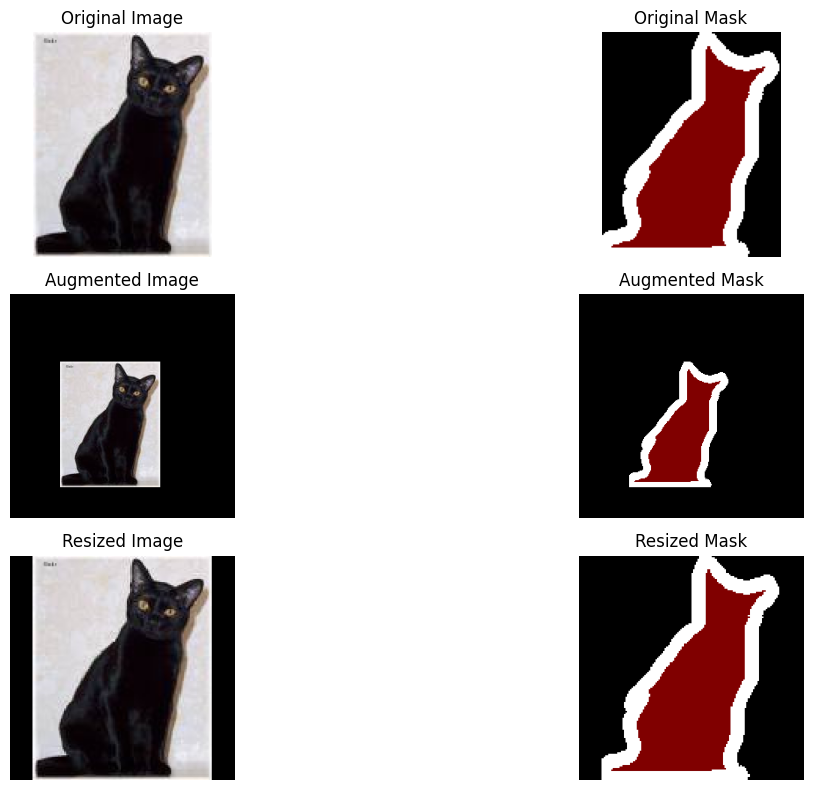

In [30]:
image = imread(os.path.join(train_path, "Bombay_103.jpg"))
mask = imread(os.path.join(train_label_path, "Bombay_103.png"))

# Convert RGBA to RGB if necessary
if image.shape[-1] == 4:
    image = image[:, :, :3]

# Define the same augmentation pipeline as used in your dataset
transform = A.Compose([
    A.PadIfNeeded(min_height=300, min_width=300, border_mode=0, value=(0, 0, 0)),  # Pad small images
    A.LongestMaxSize(max_size=300, interpolation=0),  # Resize longest side to 300 (if needed)
    A.PadIfNeeded(min_height=300, min_width=300, border_mode=0, value=(0, 0, 0)),  # Ensure final size
    A.RandomCrop(256, 256),  # Random crop
    # A.HorizontalFlip(p=0.5),
    # A.Rotate(limit=20, p=0.5),
    # A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
    # A.GridDistortion(p=0.3),
    # A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    # A.GaussianBlur(blur_limit=(3, 7), p=0.2),
    # A.GaussNoise(var_limit=(10, 50), p=0.2),
    # A.CoarseDropout(max_holes=2, max_height=50, max_width=50, p=0.3),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Apply transformations
augmented = transform(image=image, mask=mask)
aug_image, aug_mask = augmented["image"], augmented["mask"]

# Convert tensors to NumPy for visualization
aug_image = aug_image.permute(1, 2, 0).numpy()  # Change format from (C, H, W) to (H, W, C)
aug_mask = aug_mask.numpy()

transform_resize = A.Compose([
    A.LongestMaxSize(max_size=300, interpolation=0),  # Resize longest side to 300 (if needed)
    A.PadIfNeeded(min_height=300, min_width=300, border_mode=0, value=(0, 0, 0)),  # Ensure final size
    ToTensorV2()
])

resized = transform_resize(image=image, mask=mask)
resized_image, resized_mask = resized["image"], resized["mask"]
resized_image = resized_image.permute(1, 2, 0).numpy()
resized_mask = resized_mask.numpy()


# Plot original vs. transformed images vs. resized images
# fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig, axes = plt.subplots(3, 2, figsize=(15, 8))


# Original Image
axes[0, 0].imshow(image)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis("off")

# Original Mask
axes[0, 1].imshow(mask, cmap="gray")
axes[0, 1].set_title("Original Mask")
axes[0, 1].axis("off")

# Augmented Image
axes[1, 0].imshow(aug_image)
axes[1, 0].set_title("Augmented Image")
axes[1, 0].axis("off")

# Augmented Mask
axes[1, 1].imshow(aug_mask, cmap="gray")
axes[1, 1].set_title("Augmented Mask")
axes[1, 1].axis("off")

# Resized Image
axes[2, 0].imshow(resized_image)
axes[2, 0].set_title("Resized Image")
axes[2, 0].axis("off")

# Resized Mask
axes[2, 1].imshow(resized_mask, cmap="gray")
axes[2, 1].set_title("Resized Mask")
axes[2, 1].axis("off")

plt.tight_layout()
plt.show()